# **Classification of pesticide toxicity to honey bees**
## **About the dataset**

ApisTox dataset is an extensive, consistent and curated collection that focuses on the toxicity of three types of pesticides to honey bees (*Apis mellifera*) combining data from existing sources. The main information provided by this database are toxicity levels, literature related details and possible links to external chemical databases.  

## **Where to get this dataset**

The dataset is freely available in different platforms:

*  [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/995/apistox)
*   [GitHub](https://github.com/j-adamczyk/ApisTox_dataset)

Information about the creation of this database can be found at https://www.nature.com/articles/s41597-024-04232-w

## **Description of the dataset**

**Overview:**


*   Number of instances: 1035
*   Number of attributes: 11 features + 2 targets (one for binary classification and one for multiclass classification)
*   Associated task: Multiclass classification (Outcome: 0 - non-toxic, 1 - moderately toxic, 2 - highly toxic)

**Variables Description:**

1.   **name** - Chemical name, either according to IUPAC nomenclature or a commonly used trivial name.
2.   **CID** - PubChem Compound ID number.
3.   **CAS** - Chemical Abstracts Service registry number. A globally recognized identifier assigned by CAS, usually written in three blocks of numbers.
4.   **SMILES** - string Molecule structure in SMILES format (text-based representation of a molecule’s structure using specific rules).
5.   **source** - Compound source: ECOTOX, PPDB or BPDB (databases from which the compound information was collected).
6.   **year** - First publication year in literature according to PubChem.
7.   **toxicity_type** - Strongest toxicity type: Contact, Oral or Other.
8.   **herbicide** - Boolean (yes=1/no=0) feature indicating whether the chemical is used as a herbicide.
9.   **fungicide** - Boolean (yes=1/no=0) feature indicating whether the chemical is used as a fungicide.
10.  **insecticide** - Boolean (yes=1/no=0) feature indicating whether the chemical is used as an insecticide.
11.  **other_agrochemical** - Boolean (yes=1/no=0) feature indicating whether the chemical is used in other way as an agrochemical.
12.  **label** - Binary toxicity label (0 = non-toxic, 1 = toxic).
13.  **ppdb_level** - Ternary toxicity level (0 = non-toxic, 1 = moderately toxic, 2 = highly toxic)


##**Aim of the project**  

Develop a model for multiclass classification able to predict the level of a chemical's toxicity, training it with the data from Apis_tox dataset.


# **Project Pipeline**

# **0. Importing the required libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE as SK_RFE, SelectKBest as SKB, chi2
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, make_scorer, roc_auc_score, f1_score, balanced_accuracy_score, log_loss, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc

# **1. Downloading the dataset**

---


In [ ]:
# creation of a pandas DataFrame
csv_file = 'dataset_final.csv'
apis_tox = read_csv(csv_file)

In [ ]:
type(apis_tox)


pandas.core.frame.DataFrame

# **2. Exploring data with descriptive statistics**

---
## **General information**

In [ ]:
# displaying some general information about the format of the features in the database just created
apis_tox.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1035 entries, 0 to 1034
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   name                1035 non-null   object
 1   CID                 1035 non-null   int64 
 2   CAS                 1035 non-null   object
 3   SMILES              1035 non-null   object
 4   source              1035 non-null   object
 5   year                1035 non-null   int64 
 6   toxicity_type       1035 non-null   object
 7   herbicide           1035 non-null   int64 
 8   fungicide           1035 non-null   int64 
 9   insecticide         1035 non-null   int64 
 10  other_agrochemical  1035 non-null   int64 
 11  label               1035 non-null   int64 
 12  ppdb_level          1035 non-null   int64 
dtypes: int64(8), object(5)
memory usage: 105.2+ KB


In [ ]:
# printing the first part of the database in order to check thee correctness of each column
apis_tox.head()

,name,CID,CAS,SMILES,source,year,toxicity_type,herbicide,fungicide,insecticide,other_agrochemical,label,ppdb_level
0,Ethanedioic acid,971,144-62-7,O=C(O)C(=O)O,ECOTOX,1832,Contact,0,0,0,0,0,0
1,Para-cymene,7463,99-87-6,Cc1ccc(C(C)C)cc1,BPDB,1833,Other,0,0,0,1,0,1
2,Kieselguhr,24261,61790-53-2,O=[Si]=O,ECOTOX,1833,Contact,0,0,0,0,0,0
3,Benzoic acid,243,65-85-0,O=C(O)c1ccccc1,ECOTOX,1833,Contact,1,1,1,0,0,1
4,Tetradifon (Ref: ENT 23737),8305,116-29-0,O=S(=O)(c1ccc(Cl)cc1)c1cc(Cl)c(Cl)cc1Cl,PPDB,1836,Oral,0,0,0,1,1,1


We can therefore classify features as:


*   **Binary** (values are only 0/1): herbicide, fungicide, insecticide, other_agrochemical, label

*   **Categorical** (all instances distributed among few values): source (ECOTOX, PPDB, BPDB), toxicity_type (Contact, Oral, Other), ppdb_level (0, 1, 2)

*   **Numerical**: CID, year

*   **String / text**: name, CAS, SMILES

In [ ]:
# checking the dimensions of the database
print(apis_tox.shape)

(1035, 13)


In [ ]:
# printing an overview of the values of the features
print(apis_tox.describe())

                CID         year    herbicide    fungicide  insecticide  \
count  1.035000e+03  1035.000000  1035.000000  1035.000000  1035.000000   
mean   6.619015e+06  1969.225121     0.342029     0.190338     0.219324   
std    1.795840e+07    39.418115     0.474619     0.392758     0.413988   
min    2.340000e+02  1832.000000     0.000000     0.000000     0.000000   
25%    1.844950e+04  1958.000000     0.000000     0.000000     0.000000   
50%    8.613200e+04  1977.000000     0.000000     0.000000     0.000000   
75%    5.363382e+06  1995.000000     1.000000     0.000000     0.000000   
max    1.633606e+08  2023.000000     1.000000     1.000000     1.000000   

       other_agrochemical        label   ppdb_level  
count         1035.000000  1035.000000  1035.000000  
mean             0.208696     0.285990     0.994203  
std              0.406573     0.452103     0.580106  
min              0.000000     0.000000     0.000000  
25%              0.000000     0.000000     1.000000  


In [ ]:
# checking the presence of null values
apis_tox.isnull().sum()

,0
name,0
CID,0
CAS,0
SMILES,0
source,0
year,0
toxicity_type,0
herbicide,0
fungicide,0
insecticide,0


From this overview we can see that there aren't missing values.

In [ ]:
# checking the number of uniques value to invstigate how much each feature is informative
apis_tox.nunique()

,0
name,1035
CID,1030
CAS,1035
SMILES,1035
source,3
year,158
toxicity_type,3
herbicide,2
fungicide,2
insecticide,2


## **Class Distribution**

In [ ]:
# calculating the number of values for each class
toxicity_levels = apis_tox.groupby('ppdb_level')
print(toxicity_levels.size())

ppdb_level
0    177
1    687
2    171
dtype: int64


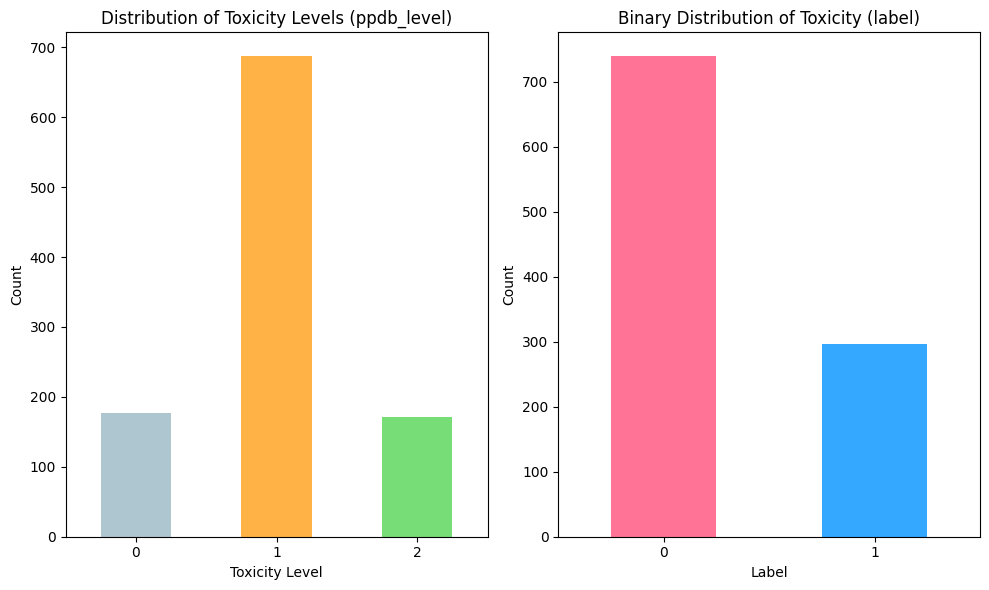

In [ ]:
# representing the class distribution with a bar plot
toxicity_counts = apis_tox.groupby('ppdb_level').size()
label_counts = apis_tox.groupby('label').size()

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
toxicity_counts.plot(kind='bar', color=['#AEC6CF', '#FFB347', '#77DD77'])
plt.title('Distribution of Toxicity Levels (ppdb_level)')
plt.xlabel('Toxicity Level')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
label_counts.plot(kind='bar', color=['#ff7496', '#34a7ff'])
plt.title('Binary Distribution of Toxicity (label)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

This representation clearly shows an imbalance between classes 1 and 2-0 in multiclass classification, and between classes 0 and 1 in binary classification.

## **Features Distribution**

In [ ]:
# Selecting only numeric columns to evaluate the distribution of numeric features
numeric_apis_tox = apis_tox.select_dtypes(include=['number'])
print(numeric_apis_tox.skew())

CID                   4.832600
year                 -1.407189
herbicide             0.666964
fungicide             1.579912
insecticide           1.358588
other_agrochemical    1.435749
label                 0.948562
ppdb_level            0.000257
dtype: float64


The skewness values show how asymmetric each feature’s distribution is compared to a normal distribution. In this case:


*   `ppdb_level` has a skew close to 0 indicating a symmetric distribution
*   `herbicide, fungicide, insecticide, other_agrochemical, label` binary features, have a positive skew probably due to class unbalance (more 0s than 1s)
*   `year` has a negative skew meaning that the distribution has more recent years concentrated at the high end, with a tail extending toward older publication years.


## **Histograms**

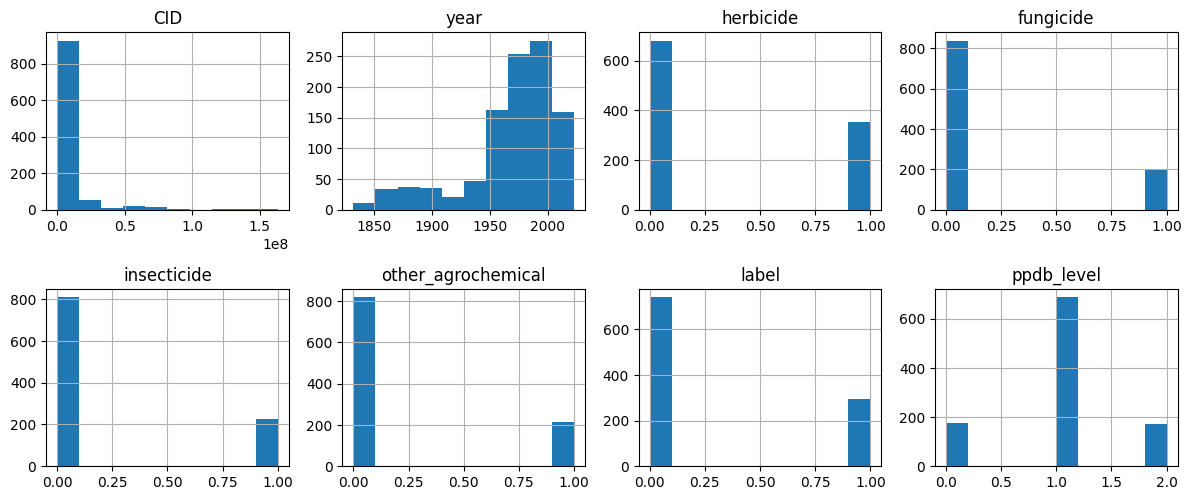

In [ ]:
# Creating a histogram for each colunm in the dataset
apis_tox.hist(figsize=(12, 10), layout=(4, 4))
plt.tight_layout()

In the histograms, the feature with the most negative skewness (year) shows a left-skewed distribution, with the tail extending toward earlier years. In contrast, the feature with the highest positive skewness (CID) displays a right-skewed distribution, with a long tail toward higher values. The feature with skewness closest to zero (ppdb_level) presents a nearly symmetric, bell-shaped histogram, consistent with the interpretation of skewness as a measure of distributional asymmetry. For the binary features (herbicide, fungicide, insecticide, other_agrochemical, label), the histograms contain only two bars, corresponding to values 0 and 1. These distributions are clearly unbalanced, with the bar for 0 substantially higher than the bar for 1, which explains their positive skewness.

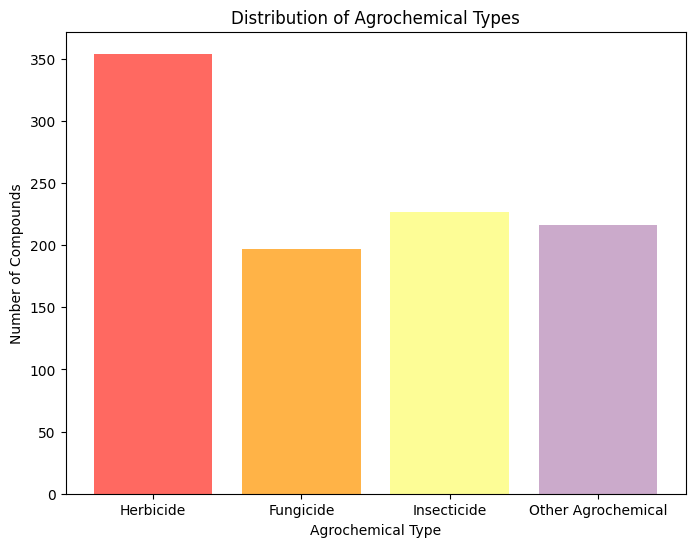

In [ ]:
# checking the distribution of various types of pesticides among the chemicals presents in the dataset
herbicide_count = apis_tox['herbicide'].sum()
fungicide_count = apis_tox['fungicide'].sum()
insecticide_count = apis_tox['insecticide'].sum()
other_agrochemical_count = apis_tox['other_agrochemical'].sum()
labels = ['Herbicide', 'Fungicide', 'Insecticide', 'Other Agrochemical']
counts = [herbicide_count, fungicide_count, insecticide_count, other_agrochemical_count]
plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=['#FF6961', '#FFB347', '#FDFD96', '#CBAACB'])
plt.title('Distribution of Agrochemical Types')
plt.xlabel('Agrochemical Type')
plt.ylabel('Number of Compounds')
plt.show()

This bar plot shows that there are more herbicide than other agrochemicals

## **Density plots**

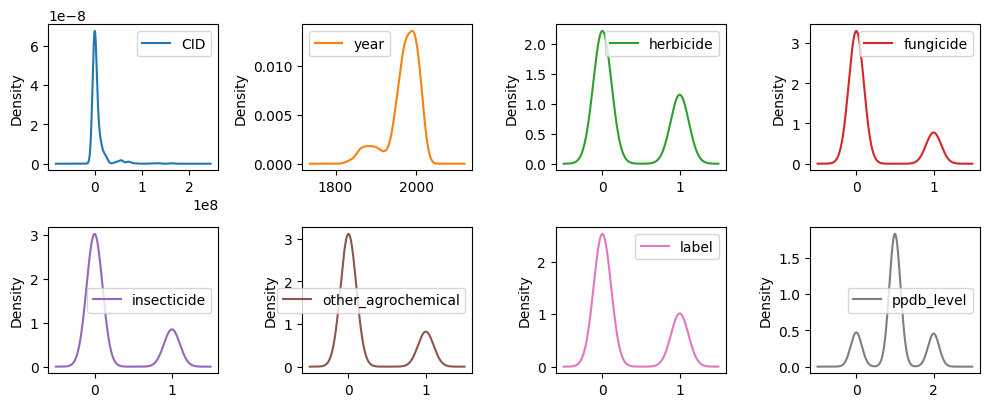

In [ ]:
# displaying the density plot for each numeric feature
apis_tox.plot(kind='density', subplots=True, layout=(4, 4), figsize=(10, 8), sharex=False)
plt.tight_layout()
plt.show()

In accordance with the previous plots, there is a left tail in the continuous column `'year'` and a right tail in the continuous column `'CID'`. The binary columns exhibit two peaks corresponding to 0 and 1, and the categorical column `ppdb_level` presents three peaks corresponding to its three categories.

## **Correlation Matrix**

In [ ]:
# calculating the correlations between each pair of columns
correlations = numeric_apis_tox.corr()
correlations

,CID,year,herbicide,fungicide,insecticide,other_agrochemical,label,ppdb_level
CID,1.000000e+00,0.264929,-0.035197,5.279098e-07,-0.030772,0.020684,-0.029227,-0.026389
year,2.649289e-01,1.000000,0.153857,2.846371e-02,-0.082206,-0.142514,-0.086647,-0.040291
herbicide,-3.519671e-02,0.153857,1.000000,-3.132572e-01,-0.367385,-0.370265,-0.330103,-0.266773
fungicide,5.279098e-07,0.028464,-0.313257,1.000000e+00,-0.215356,-0.248998,-0.170694,-0.143717
insecticide,-3.077183e-02,-0.082206,-0.367385,-2.153557e-01,1.000000,-0.272203,0.517132,0.436190
other_agrochemical,2.068378e-02,-0.142514,-0.370265,-2.489981e-01,-0.272203,1.000000,-0.051425,-0.023569
label,-2.922676e-02,-0.086647,-0.330103,-1.706937e-01,0.517132,-0.051425,1.000000,0.636893
ppdb_level,-2.638867e-02,-0.040291,-0.266773,-1.437170e-01,0.436190,-0.023569,0.636893,1.000000


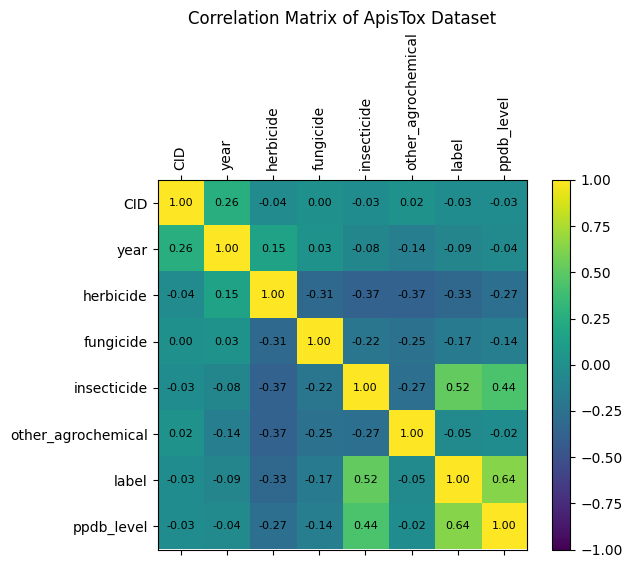


Most Positively Correlated Variable Pairs (excluding self-correlation):
ppdb_level   label          0.636893
label        ppdb_level     0.636893
             insecticide    0.517132
insecticide  label          0.517132
             ppdb_level     0.436190
ppdb_level   insecticide    0.436190
dtype: float64

Most Negatively Correlated Variable Pairs (excluding self-correlation):
herbicide           label                -0.330103
label               herbicide            -0.330103
insecticide         herbicide            -0.367385
herbicide           insecticide          -0.367385
                    other_agrochemical   -0.370265
other_agrochemical  herbicide            -0.370265
dtype: float64


In [ ]:
# plotting the correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(len(numeric_apis_tox.columns))
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(numeric_apis_tox.columns, rotation=90) # Rotate x-axis labels
ax.set_yticklabels(numeric_apis_tox.columns)
plt.title('Correlation Matrix of ApisTox Dataset')

# adding the correlation values inside the cells of the matrix
for i in range(correlations.shape[0]):
    for j in range(correlations.shape[1]):
        text = ax.text(j, i, f"{correlations.iloc[i, j]:.2f}",
                       ha="center", va="center", color="black", fontsize=8)
plt.show()

# calculating the most correlated features
stacked_corr = correlations.stack().sort_values(ascending=False)
most_correlated = stacked_corr[stacked_corr.index.get_level_values(0) != stacked_corr.index.get_level_values(1)]

print("\nMost Positively Correlated Variable Pairs (excluding self-correlation):")
print(most_correlated.head(6))
print("\nMost Negatively Correlated Variable Pairs (excluding self-correlation):")
print(most_correlated.tail(6))

The positive correlation between `ppdb_level` and `label` is consistent, as both variables represent measures of toxicity. The correlation between `label` and `insecticide` may indicate a slightly higher toxicity of `insecticides` compared to other types of pesticides. Among the negative correlations, the only potentially meaningful one is between `label` and `herbicide`, which could suggest a slightly lower toxicity of `herbicides` relative to other pesticides.

# **3. Splitting the dataset in training and test sets**

---

The dataset is split into training and test sets. This allows the model to be trained on the training set and subsequently evaluated on the test set, providing an assessment of its ability to generalize to unseen data.

In [ ]:
X = apis_tox.iloc[:,0:12].values
Y = apis_tox.iloc[:,12].astype(int).values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=2, stratify=Y)

Since an imbalance between classes was revealed by exploratory data analysis, stratification was used for the division.

# **4. Preprocessing of data**

---

This step involves cleaning and transforming the raw dataset to prepare it for modeling.

In [ ]:
# transforming back the train and test sets in DataFrames
x_train_df = pd.DataFrame(X_train, columns=['name', 'CID', 'CAS', 'SMILES', 'source', 'year', 'toxicity_type', 'herbicide', 'fungicide', 'insecticide', 'other_agrochemical', 'label'])
x_test_df = pd.DataFrame(X_test, columns=['name', 'CID', 'CAS', 'SMILES', 'source', 'year', 'toxicity_type', 'herbicide', 'fungicide', 'insecticide', 'other_agrochemical', 'label'])

# since the inclusion of the column 'label' could bring data leakage it has been dropped
x_train_df = x_train_df.drop(columns=['label'])
x_test_df = x_test_df.drop(columns=['label'])

#dividing cols based on col type (mentioned before) and selecting only the informative ones
categorical_cols = ['source', 'toxicity_type']
numerical_cols = ['year']
binary_cols = ['herbicide', 'fungicide', 'insecticide','other_agrochemical']
ignore_cols = ['name', 'CID', 'CAS', 'SMILES']

# applying the correct transformation for each column type
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numerical_cols),
        ('passthrough', 'passthrough', binary_cols)
    ],
    remainder='drop'
)
# applying the preprocessor to the dataframe
clean_X_train = preprocessor.fit_transform(x_train_df)
clean_X_test = preprocessor.transform(x_test_df)

categorical_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_transformed_cols = np.concatenate([categorical_feature_names, numerical_cols, binary_cols])
preprocessed_X_train = pd.DataFrame(clean_X_train, columns=all_transformed_cols)
preprocessed_X_test = pd.DataFrame(clean_X_test, columns=all_transformed_cols)

In [ ]:
#checking the results of preprocessing on both sets
preprocessed_X_train.head()

,source_BPDB,source_ECOTOX,source_PPDB,toxicity_type_Contact,toxicity_type_Oral,toxicity_type_Other,year,herbicide,fungicide,insecticide,other_agrochemical
0,0.0,1.0,0.0,0.0,1.0,0.0,-0.281533,0,0,0,1
1,0.0,0.0,1.0,0.0,1.0,0.0,0.348887,0,0,1,0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.575838,1,0,0,0
3,0.0,1.0,0.0,0.0,1.0,0.0,-0.256316,1,0,0,0
4,0.0,0.0,1.0,1.0,0.0,0.0,0.474971,1,0,0,0


In [ ]:
preprocessed_X_test.head()

,source_BPDB,source_ECOTOX,source_PPDB,toxicity_type_Contact,toxicity_type_Oral,toxicity_type_Other,year,herbicide,fungicide,insecticide,other_agrochemical
0,0.0,1.0,0.0,1.0,0.0,0.0,0.954091,0,1,0,0
1,0.0,1.0,0.0,0.0,0.0,1.0,-2.374529,0,0,0,0
2,0.0,1.0,0.0,0.0,1.0,0.0,-0.331967,0,0,0,1
3,0.0,1.0,0.0,1.0,0.0,0.0,-0.558918,0,0,0,0
4,0.0,0.0,1.0,1.0,0.0,0.0,-2.828431,0,1,0,0


# **5. Feature selection**

---

This step involves identifying the optimal number of features (𝑘) to retain for the model. By selecting the most relevant features, we can improve model performance, reduce overfitting, and decrease computational complexity.

In [ ]:
def model_creation(selecting_method, X_train_set, y_train_set):
  """This function uses as default method chi2 as function for SelectKBest"""
  model = LogisticRegression(solver='lbfgs', max_iter=5000)
  accuracies, k_values, features_list = [], [], []

  if selecting_method == 'SelectKBest':
    # since the function chi2 accepts only positive values, is necessary to transform each negative value in positive
    preprocessed_X_train["year"] = preprocessed_X_train["year"] + abs(preprocessed_X_train["year"].min()) + 1
    preprocessed_X_test["year"] = preprocessed_X_test["year"] + abs(preprocessed_X_test["year"].min()) + 1
    # Check non-negative values for chi2
    if (preprocessed_X_train < 0).values.any():
      raise ValueError("All feature values must be non-negative for the chi2 test.")

    for k in range(1, len(X_train_set.columns) + 1):
      sel = SKB(score_func=chi2, k=k)
      X_new = sel.fit_transform(X_train_set, y_train_set)
      selected_features = X_train_set.columns[sel.get_support()]
      cv_scores = cross_val_score(model, X_new, y_train_set, cv=10, scoring='accuracy')
      mean_score = cv_scores.mean()
      accuracies.append(mean_score)
      k_values.append(k)
      features_list.append(selected_features)

  elif selecting_method == 'RFE':

    for k in range(1, len(X_train_set.columns) + 1):
      rfe = SK_RFE(model, n_features_to_select=k)
      X_new = rfe.fit_transform(X_train_set, y_train_set)
      selected_features = X_train_set.columns[rfe.get_support()]
      cv_scores = cross_val_score(model, X_new, y_train_set, cv=10, scoring='accuracy')
      mean_score = cv_scores.mean()
      accuracies.append(mean_score)
      k_values.append(k)
      features_list.append(selected_features)

  else:
    raise ValueError("Invalid selecting_method. Use 'SelectKBest' or 'RFE'.")

  max_acc = float(max(accuracies))
  best_index = accuracies.index(max_acc)
  return max_acc, k_values[best_index], features_list[best_index]

rfe_res = model_creation('RFE', preprocessed_X_train, Y_train)
print('The best accuracy using RFE method is:', rfe_res[0])
print('The best k is:', rfe_res[1])
print('The best features are:', rfe_res[2])
Sel_res = model_creation('SelectKBest', preprocessed_X_train, Y_train)
print('The best accuracy using SKB method is:', Sel_res[0])
print('The best k is:', Sel_res[1])
print('The best features are:', Sel_res[2])


The best accuracy using RFE method is: 0.7086128364389234
The best k is: 7
The best features are: Index(['source_BPDB', 'source_PPDB', 'toxicity_type_Other', 'herbicide',
       'fungicide', 'insecticide', 'other_agrochemical'],
      dtype='object')
The best accuracy using SKB method is: 0.7070807453416149
The best k is: 3
The best features are: Index(['herbicide', 'fungicide', 'insecticide'], dtype='object')


Using two different methods to select the parameter *k* allows us to choose the features with greater reliability.

In [ ]:
# printing the features selected by both methods
intersection = []

for feature in rfe_res[2]:
  if feature in Sel_res[2]:
    intersection.append(feature)

print(intersection)

['herbicide', 'fungicide', 'insecticide']


Now we can create a reduced dataframe with the selected features.

In [ ]:
selected_train = preprocessed_X_train[intersection]
selected_test = preprocessed_X_test[intersection]
selected_train.head()

,source_BPDB,source_ECOTOX,toxicity_type_Contact,herbicide,fungicide,insecticide,other_agrochemical
0,0.0,1.0,1.0,0,0,1,0
1,1.0,0.0,1.0,0,0,0,1
2,0.0,0.0,1.0,0,0,0,1
3,0.0,0.0,0.0,1,0,0,0
4,0.0,1.0,1.0,1,0,0,0


# **6. Model Training**

---

In this step, multiple machine learning models are trained on the preprocessed training dataset. Their performance is evaluated, and the model achieving the best results is selected for subsequent predictions on unseen data.

In [ ]:
# Comparing the performances of a LogisticRegression model trained on the entire dataset and a model trained on the reduced dataset (containing only the selected features)
%%time

kfold = StratifiedKFold(n_splits=10, random_state=2, shuffle=True)
model = LogisticRegression(solver='lbfgs', max_iter=1000) # Increased max_iter
results = cross_val_score(model, preprocessed_X_train, Y_train, cv=kfold)
print(f"Accuracy: {results.mean() * 100:.2f}% ± {results.std() * 100:.2f}%")

Accuracy: 70.70% ± 4.81%
CPU times: user 1.6 s, sys: 1.28 ms, total: 1.6 s
Wall time: 1.35 s


In [ ]:
%%time
kfold = StratifiedKFold(n_splits=10, random_state=2, shuffle=True)
model = LogisticRegression(solver='lbfgs', max_iter=1000)
results = cross_val_score(model, selected_train, Y_train, cv=kfold)
print(f"Accuracy: {results.mean() * 100:.2f}% ± {results.std() * 100:.2f}%")

Accuracy: 70.70% ± 4.23%
CPU times: user 197 ms, sys: 0 ns, total: 197 ms
Wall time: 103 ms


From this comparison we can see that with the reduced dataset we can reach the same accuracy in a considerable smaller time.

## **Model comparison**

In [ ]:
models = [
    ('LR', LogisticRegression(class_weight='balanced', solver='lbfgs', max_iter=500)),
    ('LDA', LinearDiscriminantAnalysis()),
    ('KNN', KNeighborsClassifier()),
    ('CART', DecisionTreeClassifier(class_weight='balanced')),
    ('NB', GaussianNB()),
    ('SVM', SVC(class_weight='balanced', probability=True))
]

# Cross-validation
kfold = StratifiedKFold(n_splits=10, random_state=7, shuffle=True)
results = {}

for name, model in models:
    # Accuracy
    cv_acc = cross_val_score(model, selected_train, Y_train, cv=kfold, scoring='accuracy')
    mean_acc = cv_acc.mean()

    # Log Loss
    cv_logloss = cross_val_score(model, selected_train, Y_train, cv=kfold, scoring='neg_log_loss')
    mean_logloss = cv_logloss.mean()

    # Macro F1
    cv_f1 = cross_val_score(model, selected_train, Y_train, cv=kfold, scoring='f1_macro')
    mean_f1 = cv_f1.mean()

    # Balanced Accuracy
    cv_bal_acc = cross_val_score(model, selected_train, Y_train, cv=kfold, scoring='balanced_accuracy')
    mean_bal_acc = cv_bal_acc.mean()

    results[name] = {
        "Accuracy": mean_acc,
        "LogLoss": mean_logloss,
        "F1_macro": mean_f1,
        "BalancedAccuracy": mean_bal_acc,
    }

summary = pd.DataFrame(results).T
print("\nModel's performances (mean CV scores):")
print(summary)


Model's performances (mean CV scores):
      Accuracy   LogLoss  F1_macro  BalancedAccuracy
LR    0.440104 -0.921735  0.461319          0.556741
LDA   0.704224 -0.770109  0.479521          0.538713
KNN   0.655093 -4.118410  0.448604          0.525099
CART  0.437184 -1.013747  0.467176          0.578634
NB    0.649317 -1.413518  0.444042          0.519895
SVM   0.437184 -0.737212  0.467176          0.578634


From this comparison, LDA appears to be the best choice, as it achieves the highest accuracy and F1_macro, along with a LogLoss reasonably close to zero, which indicates fair stability. SVM, although it shows lower accuracy, provides good LogLoss and Balanced Accuracy and will therefore be retained for further tuning. KNN and Naive Bayes deliver decent accuracy but perform poorly in terms of F1_macro and Balanced Accuracy, so they will also be kept for tuning. The models that consistently underperforms across all metrics are Logistic Regression and CART, which will therefore be discarded.

## **Model Tuning**

Tuning of hyperparameters for the best models resulted from the previous comparison.

In [ ]:
tuned_models = {}

# SVM
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}
svm = SVC(class_weight='balanced', probability=True)
svm_grid = GridSearchCV(svm, svm_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid.fit(selected_train, Y_train)
tuned_models['SVM'] = svm_grid.best_estimator_

# KNN
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, knn_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
knn_grid.fit(selected_train, Y_train)
tuned_models['KNN'] = knn_grid.best_estimator_

# NB
nb_param_grid = {
    'var_smoothing': np.logspace(-9, -1, 9)
}
nb = GaussianNB()
nb_grid = GridSearchCV(nb, nb_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
nb_grid.fit(selected_train, Y_train)
tuned_models['NB'] = nb_grid.best_estimator_

# LDA
lda_param_grid = [
    {'solver': ['svd']},
    {'solver': ['lsqr', 'eigen'], 'shrinkage': [None, 'auto']}
]

lda = LinearDiscriminantAnalysis()
lda_grid = GridSearchCV(lda, lda_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
lda_grid.fit(selected_train, Y_train)
tuned_models['LDA'] = lda_grid.best_estimator_

In [ ]:
# cross-validation of tuned models
tuned_models = {
    "SVM": tuned_models['SVM'],
    "KNN": tuned_models['KNN'],
    "NB": tuned_models['NB'],
    "LDA": tuned_models['LDA']
}

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

def logloss_scorer(estimator, X, y):
    if hasattr(estimator, "predict_proba"):
        y_proba = estimator.predict_proba(X)
        return -log_loss(y, y_proba)
    else:
        return np.nan

for name, model in tuned_models.items():
    print(f"\n{name}")

    # Accuracy CV
    cv_acc = cross_val_score(model, selected_train, Y_train, cv=kfold, scoring='accuracy')

    # LogLoss CV
    cv_ll = cross_val_score(model, selected_train, Y_train, cv=kfold, scoring=logloss_scorer)

    print("Accuracy (post-tuning, CV): %.4f ± %.4f" % (cv_acc.mean(), cv_acc.std()))
    print("LogLoss (post-tuning, CV): %.4f ± %.4f" % (cv_ll.mean(), cv_ll.std()))



SVM
Accuracy (post-tuning, CV): 0.4934 ± 0.0889
LogLoss (post-tuning, CV): -0.7362 ± 0.0578

KNN
Accuracy (post-tuning, CV): 0.6841 ± 0.0554
LogLoss (post-tuning, CV): -2.0674 ± 1.3832

NB
Accuracy (post-tuning, CV): 0.7071 ± 0.0360
LogLoss (post-tuning, CV): -0.9445 ± 0.1832

LDA
Accuracy (post-tuning, CV): 0.7042 ± 0.0370
LogLoss (post-tuning, CV): -0.7701 ± 0.0974


Despite all models improved their performances, even after tuning, LDA proves to be the best model. Therefore, it will be used for the evaluation with the test set.

# **7. Performance evaluation**

In [ ]:
final_model = tuned_models['LDA']
final_model.fit(selected_train, Y_train)
Y_pred_test = final_model.predict(selected_test)

if hasattr(final_model, "predict_proba"):
    Y_prob_test = final_model.predict_proba(selected_test)
else:
    Y_prob_test = None

Y_pred_test = Y_pred_test.astype(int)
Y_test_int = Y_test.astype(int)

# Accuracy
acc = accuracy_score(Y_test_int, Y_pred_test)
print(f"Classification Accuracy: {acc:.3f}")

# Logarithmic Loss
if Y_prob_test is not None:
    try:
        logloss = log_loss(Y_test_int, Y_prob_test, labels=np.unique(Y_test_int))
        print(f"Logarithmic Loss: {logloss:.3f}")
    except ValueError as e:
        print(f"Could not calculate Logarithmic Loss for LDA: {e}")
        print("This might happen if the model does not predict all classes present in Y_test.")

# ROC AUC
if Y_prob_test is not None and len(np.unique(Y_test_int)) > 2:
    try:
        roc_auc = roc_auc_score(Y_test_int, Y_prob_test, multi_class='ovr', average='macro')
        print(f"ROC AUC: {roc_auc:.3f}")
    except ValueError as e:
        print(f"Could not calculate ROC AUC for LDA: {e}")
        print("Check if the model's predict_proba output is correctly structured for multiclass AUC.")
elif Y_prob_test is not None and len(np.unique(Y_test_int)) == 2:
    try:
        roc_auc = roc_auc_score(Y_test_int, Y_prob_test[:, 1])
        print(f"ROC AUC: {roc_auc:.3f}")
    except ValueError as e:
        print(f"Could not calculate Binary ROC AUC for LDA: {e}")

# Confusion Matrix
cm = confusion_matrix(Y_test_int, Y_pred_test)
print("Confusion Matrix:")
print(cm)

# Classification Report
cr = classification_report(Y_test_int, Y_pred_test, zero_division=0)
print("Classification Report:")
print(cr)


Classification Accuracy: 0.696
Logarithmic Loss: 0.786
ROC AUC: 0.674
Confusion Matrix:
[[  0  53   5]
 [  0 199  28]
 [  0  18  39]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        58
           1       0.74      0.88      0.80       227
           2       0.54      0.68      0.60        57

    accuracy                           0.70       342
   macro avg       0.43      0.52      0.47       342
weighted avg       0.58      0.70      0.63       342



These results show that the obtained model is unable to distinguish class “0”, i.e. non-toxic pesticides, incorrectly classifying all 58 examples belonging to that class. On the other hand, it manages to distinguish classes 1 and 2, albeit with numerous errors.

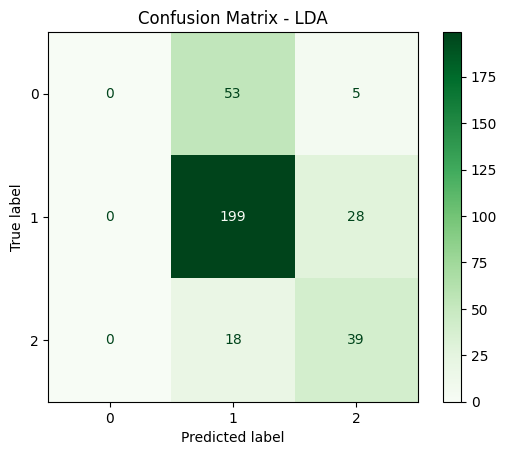

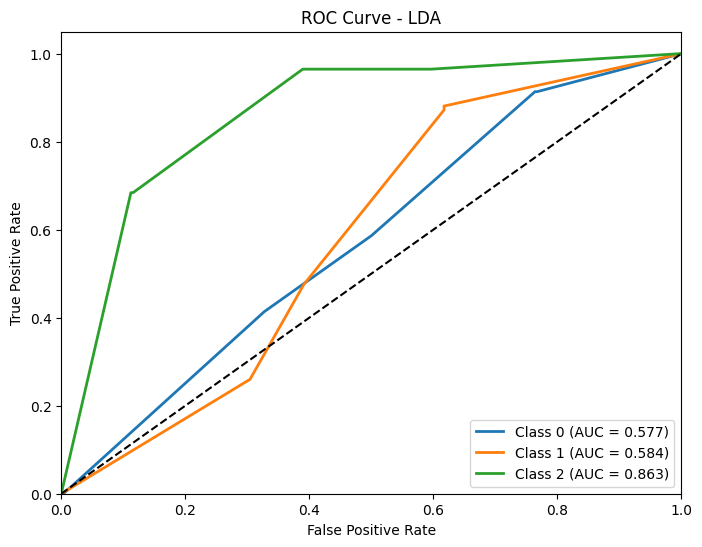

In [ ]:
# plotting the results for a better visualization
n_classes = 3
final_model = tuned_models['LDA']
final_model.fit(selected_train, Y_train)
Y_pred_test = final_model.predict(selected_test)

if hasattr(final_model, "predict_proba"):
    Y_prob_test = final_model.predict_proba(selected_test)
else:
    Y_prob_test = None

# Confusion Matrix
cm_display = ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred_test, cmap=plt.cm.Greens)
plt.title("Confusion Matrix - LDA")
plt.show()

# ROC Curve
if Y_prob_test is not None:
    Y_test_bin = label_binarize(Y_test, classes=np.arange(n_classes))

    plt.figure(figsize=(8,6))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(Y_test_bin[:, i], Y_prob_test[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.3f})')

    plt.plot([0,1], [0,1], color='black', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - LDA')
    plt.legend(loc='lower right')
    plt.show()


# **Binary classification**

---

Since multiclass classification yielded poor results, we can try to repeat the pipeline just used to build a binary classification model using the `label` column with binary outcomes, which was initially discarded, as the target.

## **Dataset split**


In [ ]:
array = apis_tox.values
W = array[:,0:11]
Z = array[:,11].astype(int)
W_train, W_test, Z_train, Z_test = train_test_split(W, Z, test_size=0.33, random_state=2, stratify=Z)
w_train_df = pd.DataFrame(W_train, columns=['name', 'CID', 'CAS', 'SMILES', 'source', 'year', 'toxicity_type', 'herbicide', 'fungicide', 'insecticide', 'other_agrochemical'])
w_test_df = pd.DataFrame(W_test, columns=['name', 'CID', 'CAS', 'SMILES', 'source', 'year', 'toxicity_type', 'herbicide', 'fungicide', 'insecticide', 'other_agrochemical'])

## **Data preprocessing**

In [ ]:
#dividing cols based on col type (mentioned before) and selecting only the informative ones
categorical_cols = ['source', 'toxicity_type']
numerical_cols = ['year']
binary_cols = ['herbicide', 'fungicide', 'insecticide','other_agrochemical']
ignore_cols = ['name', 'CID', 'CAS', 'SMILES']

# applying the correct transformation for each column type
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numerical_cols),
        ('passthrough', 'passthrough', binary_cols)
    ],
    remainder='drop'
)
# applying the preprocessor to the dataframe
clean_W_train = preprocessor.fit_transform(w_train_df)
clean_W_test = preprocessor.transform(w_test_df)

categorical_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_transformed_cols = np.concatenate([categorical_feature_names, numerical_cols, binary_cols])
preprocessed_W_train = pd.DataFrame(clean_W_train, columns=all_transformed_cols)
preprocessed_W_test = pd.DataFrame(clean_W_test, columns=all_transformed_cols)

## **Features selection**

In [ ]:
def model_creation(selecting_method, W_train_set, z_train_set):
  """This function uses as default method chi2 as function for SelectKBest"""
  model = LogisticRegression(solver='lbfgs', max_iter=5000)
  accuracies, k_values, features_list = [], [], []

  if selecting_method == 'SelectKBest':
    # since the function chi2 accepts only positive values, is necessary to transform each negative value in positive
    preprocessed_W_train["year"] = preprocessed_W_train["year"] + abs(preprocessed_W_train["year"].min()) + 1
    preprocessed_W_test["year"] = preprocessed_W_test["year"] + abs(preprocessed_W_test["year"].min()) + 1
    # Check non-negative values for chi2
    if (preprocessed_W_train < 0).values.any():
      raise ValueError("All feature values must be non-negative for the chi2 test.")

    for k in range(1, len(W_train_set.columns) + 1):
      sel = SKB(score_func=chi2, k=k)
      W_new = sel.fit_transform(W_train_set, z_train_set)
      selected_features = W_train_set.columns[sel.get_support()]
      cv_scores = cross_val_score(model, W_new, z_train_set, cv=10, scoring='accuracy')
      mean_score = cv_scores.mean()
      accuracies.append(mean_score)
      k_values.append(k)
      features_list.append(selected_features)

  elif selecting_method == 'RFE':

    for k in range(1, len(W_train_set.columns) + 1):
      rfe = SK_RFE(model, n_features_to_select=k)
      W_new = rfe.fit_transform(W_train_set, z_train_set)
      selected_features = W_train_set.columns[rfe.get_support()]
      cv_scores = cross_val_score(model, W_new, z_train_set, cv=10, scoring='accuracy')
      mean_score = cv_scores.mean()
      accuracies.append(mean_score)
      k_values.append(k)
      features_list.append(selected_features)

  else:
    raise ValueError("Invalid selecting_method. Use 'SelectKBest' or 'RFE'.")

  max_acc = float(max(accuracies))
  best_index = accuracies.index(max_acc)
  return max_acc, k_values[best_index], features_list[best_index]

rfe_results = model_creation('RFE', preprocessed_W_train, Z_train)
print('The best accuracy using RFE method is:', rfe_results[0])
print('The best k is:', rfe_results[1])
print('The best features are:', rfe_results[2])
select_k_best_results = model_creation('SelectKBest', preprocessed_W_train, Z_train)
print('The best accuracy using SKB method is:', select_k_best_results[0])
print('The best k is:', select_k_best_results[1])
print('The best features are:', select_k_best_results[2])

The best accuracy using RFE method is: 0.8282608695652174
The best k is: 7
The best features are: Index(['source_BPDB', 'source_ECOTOX', 'toxicity_type_Contact', 'herbicide',
       'fungicide', 'insecticide', 'other_agrochemical'],
      dtype='object')
The best accuracy using SKB method is: 0.8253830227743271
The best k is: 10
The best features are: Index(['source_BPDB', 'source_ECOTOX', 'source_PPDB', 'toxicity_type_Contact',
       'toxicity_type_Oral', 'year', 'herbicide', 'fungicide', 'insecticide',
       'other_agrochemical'],
      dtype='object')


## **Creating a reduced dataset**

In [ ]:
# Selecting the common features
intersection = []

for feature in rfe_results[2]:
  if feature in select_k_best_results[2]:
    intersection.append(feature)

print(intersection)

['source_BPDB', 'source_ECOTOX', 'toxicity_type_Contact', 'herbicide', 'fungicide', 'insecticide', 'other_agrochemical']


In [ ]:
# Creating a new dataset
reduced_train = preprocessed_W_train[intersection]
reduced_test = preprocessed_W_test[intersection]
reduced_train.head()

,source_BPDB,source_ECOTOX,toxicity_type_Contact,herbicide,fungicide,insecticide,other_agrochemical
0,0.0,1.0,1.0,0,0,1,0
1,1.0,0.0,1.0,0,0,0,1
2,0.0,0.0,1.0,0,0,0,1
3,0.0,0.0,0.0,1,0,0,0
4,0.0,1.0,1.0,1,0,0,0


## **Model comparison**

In [ ]:
models = [
    ('LR', LogisticRegression(class_weight='balanced', solver='lbfgs', max_iter=500)),
    ('LDA', LinearDiscriminantAnalysis()),
    ('KNN', KNeighborsClassifier()),
    ('CART', DecisionTreeClassifier(class_weight='balanced')),
    ('NB', GaussianNB()),
    ('SVM', SVC(class_weight='balanced', probability=True))
]

# Cross-validation
kfold = StratifiedKFold(n_splits=10, random_state=7, shuffle=True)
results = {}

for name, model in models:
    # Accuracy
    cv_acc = cross_val_score(model, reduced_train, Z_train, cv=kfold, scoring='accuracy')
    mean_acc = cv_acc.mean()

    # Log Loss
    cv_logloss = cross_val_score(model, reduced_train, Z_train, cv=kfold, scoring='neg_log_loss')
    mean_logloss = cv_logloss.mean()

    # Macro F1
    cv_f1 = cross_val_score(model, reduced_train, Z_train, cv=kfold, scoring='f1_macro')
    mean_f1 = cv_f1.mean()

    # Balanced Accuracy
    cv_bal_acc = cross_val_score(model, reduced_train, Z_train, cv=kfold, scoring='balanced_accuracy')
    mean_bal_acc = cv_bal_acc.mean()

    results[name] = {
        "Accuracy": mean_acc,
        "LogLoss": mean_logloss,
        "F1_macro": mean_f1,
        "BalancedAccuracy": mean_bal_acc,
    }

summary = pd.DataFrame(results).T
print("\nModel's performances (mean CV scores):")
print(summary)


Model's performances (mean CV scores):
      Accuracy   LogLoss  F1_macro  BalancedAccuracy
LR    0.818178 -0.470408  0.787871          0.806211
LDA   0.835590 -0.447731  0.793237          0.789724
KNN   0.819586 -1.820591  0.780617          0.787084
CART  0.815280 -0.849795  0.783078          0.799661
NB    0.835590 -0.721024  0.793869          0.791335
SVM   0.831222 -0.418058  0.800830          0.815222


This comparison reveals that LDA and NB achieve the highest accuracy values, while SVM, despite slightly lower accuracy, performs best in all other metrics. Furthermore, while LR shows decent values in all metrics and can therefore be considered for tuning, KNN and CART perform worst in almost all metrics and will therefore be discarded.

## **Model tuning**

In [ ]:
tuned_models = {}

# SVM hyperparameters
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}
svm = SVC(class_weight='balanced', probability=True)
svm_grid = GridSearchCV(svm, svm_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid.fit(reduced_train, Z_train)
tuned_models['SVM'] = svm_grid.best_estimator_

# LR hyperparameters
lr_param_grid = [
    {'solver': ['liblinear'], 'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'solver': ['lbfgs'], 'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}
]
lr = LogisticRegression(class_weight='balanced', max_iter=1000)
lr_grid = GridSearchCV(lr, lr_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
lr_grid.fit(reduced_train, Z_train)
tuned_models['LR'] = lr_grid.best_estimator_

# NB
nb_param_grid = {
    'var_smoothing': np.logspace(-9, -1, 9)
}
nb = GaussianNB()
nb_grid = GridSearchCV(nb, nb_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
nb_grid.fit(reduced_train, Y_train)
tuned_models['NB'] = nb_grid.best_estimator_

# LDA
lda_param_grid = [
    {'solver': ['svd']},
    {'solver': ['lsqr', 'eigen'], 'shrinkage': [None, 'auto']}
]

lda = LinearDiscriminantAnalysis()
lda_grid = GridSearchCV(lda, lda_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
lda_grid.fit(reduced_train, Y_train)
tuned_models['LDA'] = lda_grid.best_estimator_

In [ ]:
# cross-validation of tuned models
tuned_models = {
    "SVM": tuned_models['SVM'],
    "LR": tuned_models['LR'],
    "NB": tuned_models['NB'],
    "LDA": tuned_models['LDA']
}

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

def logloss_scorer(estimator, W, z):
    if hasattr(estimator, "predict_proba"):
        z_proba = estimator.predict_proba(W)
        return -log_loss(z, z_proba)
    else:
        return np.nan

for name, model in tuned_models.items():
    print(f"\n {name}")

    # Accuracy CV
    cv_acc = cross_val_score(model, reduced_train, Z_train, cv=kfold, scoring='accuracy')

    # LogLoss CV
    cv_ll = cross_val_score(model, reduced_train, Z_train, cv=kfold, scoring=logloss_scorer)

    print("Accuracy (post-tuning, CV): %.4f ± %.4f" % (cv_acc.mean(), cv_acc.std()))
    print("LogLoss (post-tuning, CV): %.4f ± %.4f" % (cv_ll.mean(), cv_ll.std()))


 SVM
Accuracy (post-tuning, CV): 0.8370 ± 0.0435
LogLoss (post-tuning, CV): -0.4303 ± 0.0737

 LR
Accuracy (post-tuning, CV): 0.8312 ± 0.0455
LogLoss (post-tuning, CV): -0.4885 ± 0.0506

 NB
Accuracy (post-tuning, CV): 0.8356 ± 0.0445
LogLoss (post-tuning, CV): -0.5663 ± 0.1728

 LDA
Accuracy (post-tuning, CV): 0.8356 ± 0.0406
LogLoss (post-tuning, CV): -0.4477 ± 0.1127


After tuning, the SVM model improved in accuracy, resulting in the best model to date, as also evidenced by its lower logloss deviation, which indicates greater model stability.

## **Performance evaluation**

In [ ]:
final_model = tuned_models['LDA']
final_model.fit(reduced_train, Z_train)
Z_pred_test = final_model.predict(reduced_test).astype(int)
Z_test_int = Z_test.astype(int)
Z_prob_test = final_model.predict_proba(reduced_test) if hasattr(final_model, "predict_proba") else None

# Accuracy
acc = accuracy_score(Z_test_int, Z_pred_test)
print(f"Classification Accuracy: {acc:.3f}")

# Logarithmic Loss
if Z_prob_test is not None:
    logloss = log_loss(Z_test_int, Z_prob_test)
    print(f"Logarithmic Loss: {logloss:.3f}")

# ROC AUC
if Z_prob_test is not None:
    unique_classes = np.unique(Z_test_int)
    if len(unique_classes) == 2:
        roc_auc = roc_auc_score(Z_test_int, Z_prob_test[:, 1])
        print(f"ROC AUC: {roc_auc:.3f}")
    else:
        print("ROC AUC incalculable: in test is present only one class.")

# Confusion Matrix
cm = confusion_matrix(Z_test_int, Z_pred_test)
print("Confusion Matrix:")
print(cm)

# Classification Report
cr = classification_report(Z_test_int, Z_pred_test, zero_division=0)
print("Classification Report:")
print(cr)

Classification Accuracy: 0.784
Logarithmic Loss: 0.549
ROC AUC: 0.780
Confusion Matrix:
[[212  32]
 [ 42  56]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       244
           1       0.64      0.57      0.60        98

    accuracy                           0.78       342
   macro avg       0.74      0.72      0.73       342
weighted avg       0.78      0.78      0.78       342



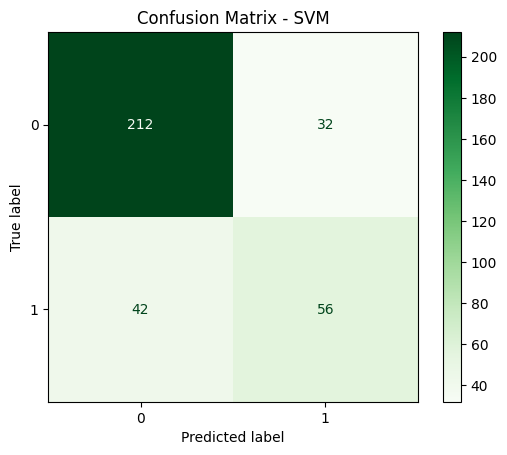

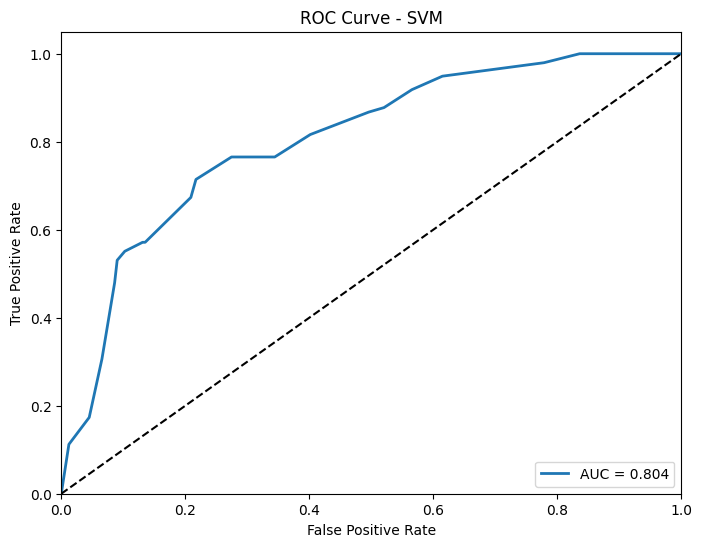

In [ ]:
# plotting the results for a better visualization
final_model = tuned_models['SVM']
final_model.fit(reduced_train, Z_train)
Z_pred_test = final_model.predict(reduced_test)
Z_prob_test = final_model.predict_proba(reduced_test)[:, 1] if hasattr(final_model, "predict_proba") else None

# Confusion Matrix
cm_display = ConfusionMatrixDisplay.from_predictions(Z_test, Z_pred_test, cmap=plt.cm.Greens)
plt.title("Confusion Matrix - SVM")
plt.show()

# ROC Curve (binary)
if Z_prob_test is not None:
    fpr, tpr, _ = roc_curve(Z_test, Z_prob_test)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.3f}')
    plt.plot([0,1], [0,1], color='black', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - SVM')
    plt.legend(loc='lower right')
    plt.show()


The SVM model for binary classification correctly predicted 212 out of 244 examples belonging to class 0, while it correctly predicted 56 out of 98 examples belonging to class 1. These results are consistent with the fact that class 1 was considerably less abundant than class 0, therefore the model has greater difficulty in distinguishing it.